In [1]:
import pandas as pd
import math
import numpy as np
import queue as pythonQueue
import networkx as nx
import matplotlib.pyplot as plt

Definitions

In [2]:
ATTRIBUTE_NAME = 0
ATTRIBUTE_HEIGHT = 1

Import data from file

In [3]:
data = pd.read_csv('adult.data', header=0, sep=', ', engine='python' )

Drop these columns:
- Fnlwgt
- Education-num
- Relationship
- Capital gain
- Capital loss
- Hours-per-week

In [4]:
data.drop(columns=['Fnlwgt', 'Education_num', 'Relationship', 'Capital_gain', 'Capital_loss', 'Hours_per_week'], inplace=True);

Drop rows in which we have unknown values ('?')

In [5]:
data.drop(data[
                (data.Workclass == '?') |
                (data.Education == '?') |
                (data.Marital_status == '?') |
                (data.Occupation == '?') |
                (data.Race == '?') |
                (data.Gender == '?') |
                (data.Native_country == '?') |
                (data.Salary == '?')].index, inplace=True);

# Domain generalization

For each remaining Q.I. and its corresponding domain, we define a generalization hierarchy, according to this (numbers in parenthesis corresponds to the height of the associated generalization hierarchy)

- Age => 5-, 10-, 20- year ranges (4)
- Workclass => Taxonomy tree (2)
- Education =>  Taxonomy tree (2)
- Marital status => Taxonomy tree (2)
- Occupation => Taxonomy tree (2)
- Race => Suppression (1)
- Gender => Suppression (1)
- Native country => Taxonomy tree (2)
- Salary => Suppression (1)

Code's rule:

the less general version of the data of the Q.I. called 'pippo' is in data['pippo'] . 

For each generalization level n, we will have a variable called pippo_n containing the generalization of the values in data['pippo'], where pippo_1 is LESS general than pippo_2 

### Domain generalization for Age
- 5- year ranges
- 10- year ranges
- 20- year ranges

In [6]:
age = pd.DataFrame(columns=('age_0','age_1', 'age_2', 'age_3'))
age['age_0'] = data['Age']
age['age_1'] = (data['Age']/5).apply(math.floor)*5
age['age_2'] = (data['Age']/10).apply(math.floor)*10
age['age_3'] = (data['Age']/20).apply(math.floor)*20

### Domain generalization for Workclass

- Private => Private => Working
- Self-emp-not-inc => Self-Emp => Working
- Self-emp-inc => Self-Emp => Working
- Federal-gov => Federal-gov => Working
- Local-gov => Other-gov => Working
- State-gov => Other-gov => Working
- Without-pay => Not-Working => Not-Working
- Never-worked => Not-Working => Not-Working

In [7]:
workclass = pd.DataFrame(columns=('workclass_0','workclass_1', 'workclass_2'))

workclass['workclass_0'] = data['Workclass']

workclass['workclass_1'] = workclass['workclass_0']
workclass['workclass_1'].where(workclass['workclass_1'] != 'Self-emp-inc', 'Self-Emp', inplace=True)
workclass['workclass_1'].where(workclass['workclass_1'] != 'Self-emp-not-inc', 'Self-Emp', inplace=True)
workclass['workclass_1'].where(workclass['workclass_1'] != 'Local-gov', 'Other-gov', inplace=True)
workclass['workclass_1'].where(workclass['workclass_1'] != 'State-gov', 'Other-gov', inplace=True)
workclass['workclass_1'].where(workclass['workclass_1'] != 'Never-worked', 'Not-Working', inplace=True)
workclass['workclass_1'].where(workclass['workclass_1'] != 'Without-pay', 'Not-Working', inplace=True)

workclass['workclass_2'] = workclass['workclass_1']
workclass['workclass_2'].where(workclass['workclass_2'] != 'Self-Emp', 'Working', inplace=True)
workclass['workclass_2'].where(workclass['workclass_2'] != 'Federal-gov', 'Working', inplace=True)
workclass['workclass_2'].where(workclass['workclass_2'] != 'Other-gov', 'Working', inplace=True)
workclass['workclass_2'].where(workclass['workclass_2'] != 'Private', 'Working', inplace=True)

### Domain generalization for Education

- "^10th" => "Dropout" => "Low"

- "^11th" => "Dropout" => "Low"

- "^12th" => "Dropout" => "Low"

- "^1st-4th" => "Dropout" => "Low"

- "^5th-6th" => "Dropout" => "Low"

- "^7th-8th" => "Dropout" => "Low"

- "^9th" => "Dropout" => "Low"

- "^Preschool" => "Dropout" => "Low"

- "^Assoc-acdm" => "Associates" => "High"

- "^Assoc-voc" => "Associates" => "High"

- "^Bachelors" => "Bachelors" => "High"

- "^Doctorate" => "Doctorate" => "High"

- "^HS-Grad" => "HS-Graduate" => "High"

- "^Masters" => "Masters" => "High"

- "^Prof-school" => "Prof-School" => "High"

- "^Some-college" => "HS-Graduate" => "High"


In [8]:
education = pd.DataFrame(columns=('education_0', 'education_1', 'education_2'))

education['education_0'] = data['Education']

education['education_1'] = education['education_0']
education['education_1'].where(education['education_1'] != '10th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '11th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '12th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '1st-4th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '5th-6th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '7th-8th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != '9th', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != 'Preschool', 'Dropout', inplace=True)
education['education_1'].where(education['education_1'] != 'Assoc-voc', 'Associates', inplace=True)
education['education_1'].where(education['education_1'] != 'Assoc-acdm', 'Associates', inplace=True)
education['education_1'].where(education['education_1'] != 'HS-grad', 'HS-Graduate', inplace=True)
education['education_1'].where(education['education_1'] != 'Some-college', 'HS-Graduate', inplace=True)

education['education_2'] = education['education_1']
education['education_2'].where(education['education_2'] != 'Dropout', 'Low', inplace=True)
education['education_2'].where(education['education_2'] != 'Prof-school', 'High', inplace=True)
education['education_2'].where(education['education_2'] != 'Associates', 'High', inplace=True)
education['education_2'].where(education['education_2'] != 'Bachelors', 'High', inplace=True)
education['education_2'].where(education['education_2'] != 'Masters', 'High', inplace=True)
education['education_2'].where(education['education_2'] != 'HS-Graduate', 'High', inplace=True)
education['education_2'].where(education['education_2'] != 'Doctorate', 'High', inplace=True)

### Domain generalization for Marital status

- Widowed => Widowed => Married
- Divorced => Not-Married => Not-Married
- Married-AF-spouse => Married => Married
- Separated => Not-Married => Not-Married
- Married-spouse-absent => Not-Married => Not-Married
- Married-civ-spouse => Married => Married
- Never-married => Never-Married => Not-Married

In [9]:
marital_status = pd.DataFrame(columns=('marital_status_0', 'marital_status_1', 'marital_status_2'))

marital_status['marital_status_0'] = data['Marital_status']

marital_status['marital_status_1'] = marital_status['marital_status_0']
marital_status['marital_status_1'].where(marital_status['marital_status_1'] != 'Divorced', 'Not-Married', inplace=True)
marital_status['marital_status_1'].where(marital_status['marital_status_1'] != 'Married-AF-spouse', 'Married', inplace=True)
marital_status['marital_status_1'].where(marital_status['marital_status_1'] != 'Separated', 'Not-Married', inplace=True)
marital_status['marital_status_1'].where(marital_status['marital_status_1'] != 'Married-spouse-absent', 'Not-Married', inplace=True)
marital_status['marital_status_1'].where(marital_status['marital_status_1'] != 'Married-civ-spouse', 'Married', inplace=True)

marital_status['marital_status_2'] = marital_status['marital_status_1']
marital_status['marital_status_2'].where(marital_status['marital_status_2'] != 'Widowed', 'Married', inplace=True)
marital_status['marital_status_2'].where(marital_status['marital_status_2'] != 'Never-married', 'Not-Married', inplace=True)

### Domain generalization for Occupation
- Adm-clerical => Admin => A
- Armed-Forces => Military => A
- Craft-repair => Blue-Collar => B
- Exec-managerial => White-Collar => A
- Farming-fishing => Blue-Collar => B
- Handlers-cleaners => Blue-Collar => B
- Machine-op-inspct => Blue-Collar => B
- Other-service => Service => B
- Priv-house-serv => Service => B
- Prof-specialty => Other-Occupations => A
- Protective-serv => Other-Occupations => A
- Sales => Sales => B
- Tech-support => Other-Occupations => A
- Transport-moving => Other-Occupations => A

In [10]:
occupation = pd.DataFrame(columns=('occupation_0','occupation_1', 'occupation_2'))

occupation['occupation_0'] = data['Occupation']

occupation['occupation_1'] = occupation['occupation_0']
occupation['occupation_1'].where(occupation['occupation_1'] != 'Adm-clerical', 'Admin', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Armed-Forces', 'Military', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Craft-repair', 'Blue-Collar', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Exec-managerial', 'White-Collar', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Farming-fishing', 'Blue-Collar', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Handlers-cleaners', 'Blue-Collar', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Machine-op-inspct', 'Blue-Collar', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Other-service', 'Service', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Priv-house-serv', 'Service', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Prof-specialty', 'Other-Occupations', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Protective-serv', 'Other-Occupations', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Tech-support', 'Other-Occupations', inplace=True)
occupation['occupation_1'].where(occupation['occupation_1'] != 'Transport-moving', 'Other-Occupations', inplace=True)

occupation['occupation_2'] = occupation['occupation_1']
occupation['occupation_2'].where(occupation['occupation_2'] != 'Military', 'A', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'Sales', 'B', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'Admin', 'A', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'White-Collar', 'A', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'Other-Occupations', 'A', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'Service', 'B', inplace=True)
occupation['occupation_2'].where(occupation['occupation_2'] != 'Blue-Collar', 'B', inplace=True)

### Domain generalization for Race
Based on suppression

In [11]:
race = pd.DataFrame(columns=('race_0','race_1'))

race['race_0'] = data['Race']
race['race_1'] = race['race_0']
race['race_1'].where(race['race_1'] != race['race_1'], '*', inplace=True)

### Domain generalization for Gender

Based on suppression

In [12]:
gender = pd.DataFrame(columns=('gender_0', 'gender_1'))

gender['gender_0'] = data['Gender']
gender['gender_1'] = gender['gender_0']
gender['gender_1'].where(gender['gender_1'] != gender['gender_1'], '*', inplace=True)

### Domain generalization for Native Country

- Cambodia => SE-Asia => Asia
- Canada => British-Commonwealth => British-Commonwealth   
- China => Asia => Asia
- Columbia => South-America => South-America
- Cuba => Latin-America => South-America
- Dominican-Republic => Latin-America => South-America
- Ecuador => South-America => South-America
- El-Salvador => South-America => South-America
- England => British-Commonwealth => British-Commonwealth
- France => Euro_1 => Europe
- Germany => Euro_1 => Europe
- Greece => Euro_2 => Europe
- Guatemala => Latin-America => South-America
- Haiti => Latin-America => South-America
- Holand-Netherlands => Euro_1 => Europe
- Honduras => Latin-America => South-America
- Hong => Asia => Asia
- Hungary => Euro_2 => Europe
- India => British-Commonwealth => British-Commonwealth
- Iran => Asia => Asia
- Ireland => British-Commonwealth => British-Commonwealth
- Italy => Euro_1 => Europe
- Jamaica => Latin-America => South-America
- Japan => Asia => Asia
- Laos => SE-Asia => Asia
- Mexico => Latin-America => South-America
- Nicaragua => Latin-America => South-America
- Outlying-US(Guam-USVI-etc) => Latin-America => South-America
- Peru => South-America => South-America
- Philippines => SE-Asia => Asia
- Poland => Euro_2 => Europe
- Portugal => Euro_2 => Europe
- Puerto-Rico => Latin-America => South-America
- Scotland => British-Commonwealth => British-Commonwealth
- South => Euro_2 => Europe
- Taiwan => Asia => Asia
- Thailand => SE-Asia => Asia
- Trinadad&Tobago => Latin-America => South-America
- United-States => United-States => United-States
- Vietnam => SE-Asia => Asia
- Yugoslavia => Euro_2 => Europe

In [13]:
native_country = pd.DataFrame(columns=('native_country_0', 'native_country_1', 'native_country_2'))

native_country['native_country_0'] = data['Native_country']

native_country['native_country_1'] = native_country['native_country_0']

native_country['native_country_1'].where(native_country['native_country_1'] != 'Cambodia', 'SE-Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Canada', 'British-Commonwealth', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'China', 'Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Columbia', 'South-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Cuba', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Dominican-Republic', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Ecuador', 'South-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'El-Salvador', 'South-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'England', 'British-Commonwealth', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'France', 'Euro_1', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Germany', 'Euro_1', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Greece', 'Euro_2', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Guatemala', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Haiti', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Holand-Netherlands', 'Euro_1', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Honduras', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Hong', 'Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Hungary', 'Euro_2', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'India', 'British-Commonwealth', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Iran', 'Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Ireland', 'British-Commonwealth', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Italy', 'Euro_1', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Jamaica', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Japan', 'Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Laos', 'SE-Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Mexico', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Nicaragua', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Outlying-US(Guam-USVI-etc)', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Peru', 'South-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Philippines', 'SE-Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Poland', 'Euro_2', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Portugal', 'Euro_2', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Puerto-Rico', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Scotland', 'British-Commonwealth', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'South', 'Euro_2', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Taiwan', 'Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Thailand', 'SE-Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Trinadad&Tobago', 'Latin-America', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Vietnam', 'SE-Asia', inplace=True)
native_country['native_country_1'].where(native_country['native_country_1'] != 'Yugoslavia', 'Euro_2', inplace=True)

native_country['native_country_2'] = native_country['native_country_1']
native_country['native_country_2'].where(native_country['native_country_2'] != 'Euro_1', 'Europe', inplace=True)
native_country['native_country_2'].where(native_country['native_country_2'] != 'Euro_2', 'Europe', inplace=True)
native_country['native_country_2'].where(native_country['native_country_2'] != 'SE-Asia', 'Asia', inplace=True)
native_country['native_country_2'].where(native_country['native_country_2'] != 'Latin-America', 'South-America', inplace=True)

### Domain generalization for Salary

Based on suppression

In [14]:
salary = pd.DataFrame(columns=('salary_0','salary_1'))

salary['salary_0'] = data['Salary']
salary['salary_1'] = salary['salary_0']
salary['salary_1'].where(salary['salary_1'] != salary['salary_1'], '*', inplace=True)

### Domains to array

In [49]:
dimensions = {}
dimensions['age']=age
dimensions['workclass'] = workclass
dimensions['education']=education
dimensions['marital_status']=marital_status
dimensions['occupation']=occupation
dimensions['race']=race
dimensions['gender']=gender
dimensions['native_country']=native_country
dimensions['salary']=salary
data_concat = data
for dimension in dimensions:
    data_concat = pd.concat([data_concat, dimensions[dimension]], axis=1)
    
data_concat

,Age,Workclass,Education,Marital_status,Occupation,Race,Gender,Native_country,Salary,age_0,...,occupation_2,race_0,race_1,gender_0,gender_1,native_country_0,native_country_1,native_country_2,salary_0,salary_1
0,39,State-gov,Bachelors,Never-married,Adm-clerical,White,Male,United-States,<=50K,39,...,A,White,*,Male,*,United-States,United-States,United-States,<=50K,*
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,United-States,<=50K,50,...,A,White,*,Male,*,United-States,United-States,United-States,<=50K,*
2,38,Private,HS-grad,Divorced,Handlers-cleaners,White,Male,United-States,<=50K,38,...,B,White,*,Male,*,United-States,United-States,United-States,<=50K,*
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Black,Male,United-States,<=50K,53,...,B,Black,*,Male,*,United-States,United-States,United-States,<=50K,*
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Black,Female,Cuba,<=50K,28,...,A,Black,*,Female,*,Cuba,Latin-America,South-America,<=50K,*
5,37,Private,Masters,Married-civ-spouse,Exec-managerial,White,Female,United-States,<=50K,37,...,A,White,*,Female,*,United-States,United-States,United-States,<=50K,*
6,49,Private,9th,Married-spouse-absent,Other-service,Black,Female,Jamaica,<=50K,49,...,B,Black,*,Female,*,Jamaica,Latin-America,South-America,<=50K,*
7,52,Self-emp-not-inc,HS-grad,Married-civ-spouse,Exec-managerial,White,Male,United-States,>50K,52,...,A,White,*,Male,*,United-States,United-States,United-States,>50K,*
8,31,Private,Masters,Never-married,Prof-specialty,White,Female,United-States,>50K,31,...,A,White,*,Female,*,United-States,United-States,United-States,>50K,*
9,42,Private,Bachelors,Married-civ-spouse,Exec-managerial,White,Male,United-States,>50K,42,...,A,White,*,Male,*,United-States,United-States,United-States,>50K,*


### Graph utilities

### Graph definition
Each node of the graph is a generalization. A node is a tuple of tuples (tuple_1, tuple_2, ..., tuple_n).
Each tuple_i is composed as (Attribute_name, Attribute_generalization).
Ex. (('Age', 0), ('Sex', 0)) is a generalization with respect to columns age_0, sex_0

In [110]:
def generate_graph_0(Q, dimensions):
    G = nx.DiGraph()
    for dimension_name in Q:
        prev = None
        height = 0
        for _ in dimensions[dimension_name].columns:
            l = [(dimension_name, height)]
            #Convert the list to tuple to make it hashable
            current_node = tuple(l)
            
            if prev is not None:
                #from ((age, 0)) to ((age, 1)), then ((age,1)) to ((age, 2))
                G.add_edge(prev, current_node)
                
            height = height + 1
            prev = current_node
    
    return G

In [99]:
def printGraph(G):
    labels = {node:str(node) for node in G.nodes()}
    print(labels)
    nx.draw(G, with_labels=True, labels=labels)
    plt.show()
            

# Incognito algorithm

In [101]:
def frequencySet_standard(T, Q):
    fsSet = T.groupby(Q).count().reset_index()
    fsSet = fsSet.iloc[:, :(len(Q)+1)]
    fsSet.rename({fsSet.columns[(len(Q))] : 'Count'}, axis='columns', inplace=True)

    return fsSet

In [121]:
def frequencySet_fromParent(T, Q):
    fsSet = T.groupby(Q)['Count'].sum().reset_index()
    fsSet = fsSet.iloc[:, :(len(Q)+1)]
    #Rename last column to "Count"
    fsSet.rename({fsSet.columns[(len(Q))] : 'Count'}, axis='columns', inplace=True)

    return fsSet

In [77]:
def computeK(frequencySet):
    return min(frequencySet['Count'])

#### Generate attributes list.  For each attribute, include all its generalizations. 
Ex. if current node is age_1, we shoud group by age_1, age_2 and age_3 because the latter ones will be needed in next iterations in parentFrequencySet. Of course group by(age_1) has the same number of rows of group by (age_1, age_2, age_3)

In [128]:
def getAllAttributesGeneralizations(node, generalizations):
    attributesOfNode = list()
    for attribute in list(node):
            # 0 is the name, 1 is the generalization level
            attributeGeneralizaiton = generalizations[attribute[ATTRIBUTE_NAME]]
            
            for i in range(attribute[ATTRIBUTE_HEIGHT], len(attributeGeneralizaiton.columns)):
                attributesOfNode.append("{}_{}".format(attribute[ATTRIBUTE_NAME], i))
                
    return attributesOfNode

In [129]:
def getNodeHeight(node):
        height = 0
        for nodeAttr in node:
            height = height + nodeAttr[ATTRIBUTE_HEIGHT]
        return height

In [130]:
def incognito_standard (k, T, Q, generalizations):
    
    queue = pythonQueue.PriorityQueue()
    
    # Must be initialized outside the for since will be both shared between iterations...
    C_i = generate_graph_0(Q, generalizations) # Graph (C_i, E_i) at iteration i
    S_i = None
    sink = list((node for node, out_degree in C_i.out_degree() if out_degree == 0))[0]
    for i in range(0, len(Q)-3):
        S_i = C_i.copy()
        marked = set()
        
        # Insert all roots node into queue, keeping queue sorted by height
        for node in C_i.nodes():
            if C_i.in_degree(node) == 0:
                height =getNodeHeight(node)
                # First parameter is height, second is data
                queue.put((height, node))
        
        while not queue.empty():
            height, node = queue.get()
            if node not in marked:
                # Ex. attributesOfNode = [age_0, age_1, age_2, sex_1, sex_2]
                attributesOfNode = getAllAttributesGeneralizations(node, generalizations) 
                # if node was initally a root
                if C_i.in_degree(node) == 0:
                    frequencySet = frequencySet_standard(T, attributesOfNode)
                else:
                    frequencySetParent = S_i.node[node]['parentFrequencySet']
                    frequencySet = frequencySet_fromParent(frequencySetParent, attributesOfNode)
                
                actual_k = computeK(frequencySet)
                # If T is k-anonymous with respect to attributes of node
                if (actual_k >= k):
                    # mark all direct generalizations of node
                    for generalizationPath in nx.all_simple_paths(S_i, source=node, target=sink):
                        for pathNode in generalizationPath:
                            marked.add(pathNode)
                else:
                    # Set childs frequency set to this one
                    for child in S_i.out_edges(node):
                        S_i.node[child[1]]['parentFrequencySet'] = frequencySet
                        height =getNodeHeight(child[1])
                        queue.put((height, child[1]))
                        
                    #print("Removed node: {}".format(node))
                    S_i.remove_node(node)
                    
        #COMPUTE C_i+1
    return S_i

# Tests

Some code to do tests and similar

In [22]:
# Example of dataframe, supposed to be 1-anonymous

exampleDF = pd.DataFrame(columns=('Name','Age', 'Gender', 'State_domicile', 'Religion', 'Disease'))
exampleDF.loc[0] = ['Ramsha' ,30 ,'Female' ,'Tamil Nadu' ,'Hindu' ,'Cancer']
exampleDF.loc[1] = ['Yadu' ,24 ,'Female' ,'Kerala' ,'Hindu' ,'Viral infection']
exampleDF.loc[2] = ['Salima' ,28 ,'Female' ,'Tamil Nadu' ,'Muslim' ,'TB']
exampleDF.loc[3] = ['Sunny' ,27 ,'Male' ,'Karnataka' ,'Parsi' ,'No illness']
exampleDF.loc[4] = ['Joan' ,24 ,'Female' ,'Kerala' ,'Christian' ,'Heart-related']
exampleDF.loc[5] = ['Bahuksana' ,23 ,'Male' ,'Karnataka' ,'Buddhist' ,'TB']
exampleDF.loc[6] = ['Rambha' ,19 ,'Male' ,'Kerala' ,'Hindu' ,'Cancer']
exampleDF.loc[7] = ['Kishor' ,29 ,'Male' ,'Karnataka' ,'Hindu' ,'Heart-related']
exampleDF.loc[8] = ['Johnson' ,17 ,'Male' ,'Kerala' ,'Christian' ,'Heart-related']
exampleDF.loc[9] = ['John' ,19 ,'Male' ,'Kerala' ,'Christian' ,'Viral infection']

In [23]:
# the same dataframe but anonymized, it is supposed to be 2-anonymous with respect to Age, Gender, State_domicile

exampleDF_anonymized = pd.DataFrame(columns=('Name','Age', 'Gender', 'State_domicile', 'Religion', 'Disease'))
exampleDF_anonymized.loc[0] = ['*', '20 < Age < 30', 'Female', 'Tamil Nadu','*', 'Cancer']
exampleDF_anonymized.loc[1] = ['*', '20 < Age < 30', 'Female', 'Kerala', '*', 'Viral infection']
exampleDF_anonymized.loc[2] = ['*', '20 < Age < 30', 'Female','Tamil Nadu', '*', 'TB']
exampleDF_anonymized.loc[3] = ['*', '20 < Age < 30', 'Male', 'Karnataka', '*', 'No illness']
exampleDF_anonymized.loc[4] = ['*', '20 < Age < 30', 'Female', 'Kerala', '*', 'Heart-related']
exampleDF_anonymized.loc[5] = ['*', '20 < Age < 30', 'Male', 'Karnataka', '*', 'TB']
exampleDF_anonymized.loc[6] = ['*', 'Age < 20', 'Male', 'Kerala', '*', 'Cancer']
exampleDF_anonymized.loc[7] = ['*', '20 < Age < 30', 'Male', 'Karnataka', '*', 'Heart-related']
exampleDF_anonymized.loc[8] = ['*', 'Age < 20', 'Male', 'Kerala',  '*', 'Heart-related']
exampleDF_anonymized.loc[9] = ['*', 'Age < 20', 'Male', 'Kerala', '*', 'Viral infection']

In [24]:
frequencySet_standard(exampleDF, ['Age', 'Gender', 'State_domicile'])

,Age,Gender,State_domicile,Count
0,17,Male,Kerala,1
1,19,Male,Kerala,2
2,23,Male,Karnataka,1
3,24,Female,Kerala,2
4,27,Male,Karnataka,1
5,28,Female,Tamil Nadu,1
6,29,Male,Karnataka,1
7,30,Female,Tamil Nadu,1


In [25]:
frequencySet_standard(exampleDF_anonymized, ['Age', 'Gender', 'State_domicile'])

,Age,Gender,State_domicile,Count
0,20 < Age < 30,Female,Kerala,2
1,20 < Age < 30,Female,Tamil Nadu,2
2,20 < Age < 30,Male,Karnataka,3
3,Age < 20,Male,Kerala,3


In [26]:
fSet = frequencySet_standard(data[:30], ['Age', 'Workclass', 'Education', 'Marital_status'])
fSet

,Age,Workclass,Education,Marital_status,Count
0,19,Private,HS-grad,Never-married,1
1,20,Private,Some-college,Never-married,1
2,23,Local-gov,Assoc-acdm,Never-married,1
3,23,Private,Bachelors,Never-married,1
4,25,Self-emp-not-inc,HS-grad,Never-married,1
5,28,Private,Bachelors,Married-civ-spouse,1
6,30,State-gov,Bachelors,Married-civ-spouse,1
7,31,Private,Masters,Never-married,1
8,32,Private,Assoc-acdm,Never-married,1
9,32,Private,HS-grad,Never-married,1


In [27]:
tmpAge = pd.DataFrame({'age_0' : np.sort(pd.unique(data['Age']))})
tmpAge['age_1'] = (tmpAge['age_0']/5).apply(math.floor)*5
tmpAge['age_2'] = (tmpAge['age_0']/10).apply(math.floor)*10
tmpAge['age_3'] = (tmpAge['age_0']/20).apply(math.floor)*20

fSet = frequencySet_standard(data[:50], ['Age', 'Workclass', 'Education', 'Marital_status'])

fSet.join(tmpAge.set_index('age_0'), on='Age')

,Age,Workclass,Education,Marital_status,Count,age_1,age_2,age_3
0,19,Private,HS-grad,Married-AF-spouse,1,15,10,0
1,19,Private,HS-grad,Never-married,1,15,10,0
2,20,Private,Some-college,Never-married,1,20,20,20
3,21,Private,Some-college,Never-married,1,20,20,20
4,22,State-gov,Some-college,Married-civ-spouse,1,20,20,20
5,23,Local-gov,Assoc-acdm,Never-married,1,20,20,20
6,23,Private,Bachelors,Never-married,1,20,20,20
7,24,Private,Bachelors,Married-civ-spouse,1,20,20,20
8,25,Private,HS-grad,Never-married,1,25,20,20
9,25,Private,Some-college,Married-civ-spouse,1,25,20,20


None->(('Age', 0),)
(('Age', 0),)->(('Age', 1),)
(('Age', 1),)->(('Age', 2),)
(('Age', 2),)->(('Age', 3),)
None->(('Workclass', 0),)
(('Workclass', 0),)->(('Workclass', 1),)
(('Workclass', 1),)->(('Workclass', 2),)
None->(('Education', 0),)
(('Education', 0),)->(('Education', 1),)
(('Education', 1),)->(('Education', 2),)
None->(('Marital_status', 0),)
(('Marital_status', 0),)->(('Marital_status', 1),)
(('Marital_status', 1),)->(('Marital_status', 2),)
{(('Age', 0),): "(('Age', 0),)", (('Age', 1),): "(('Age', 1),)", (('Age', 2),): "(('Age', 2),)", (('Age', 3),): "(('Age', 3),)", (('Workclass', 0),): "(('Workclass', 0),)", (('Workclass', 1),): "(('Workclass', 1),)", (('Workclass', 2),): "(('Workclass', 2),)", (('Education', 0),): "(('Education', 0),)", (('Education', 1),): "(('Education', 1),)", (('Education', 2),): "(('Education', 2),)", (('Marital_status', 0),): "(('Marital_status', 0),)", (('Marital_status', 1),): "(('Marital_status', 1),)", (('Marital_status', 2),): "(('Marital_statu

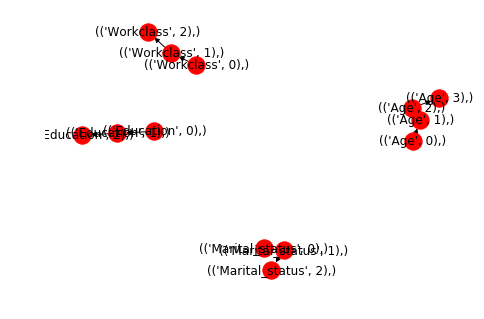

In [30]:
graph = generate_graph_0( ['Age', 'Workclass', 'Education', 'Marital_status'], dimensions)
printGraph(graph)

{(('age', 3),): "(('age', 3),)", (('education', 1),): "(('education', 1),)", (('education', 2),): "(('education', 2),)", (('marital_status', 1),): "(('marital_status', 1),)", (('marital_status', 2),): "(('marital_status', 2),)"}


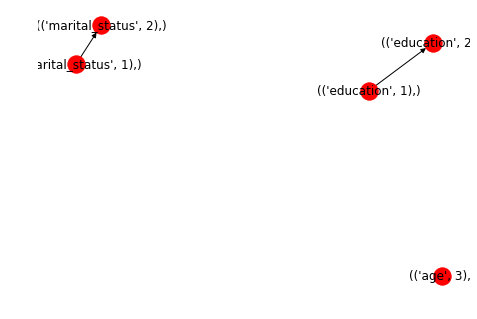

In [132]:
G = incognito_standard(50, data_concat, ['age', 'workclass', 'education', 'marital_status'], dimensions  )

printGraph(G)

In [ ]:
#frequencySet_standard(data, ['Age_1'])
attributesOfNode = getAllAttributesGeneralizations([('Age', 0)], dimensions)   
print(attributesOfNode)
frequencySet = frequencySet_standard(T, attributesOfNode)